# HW 6 Assignment 1
## Author: Sofiya Elyukin

## Getting and preparing energy data

In [1]:
from __future__ import print_function, division
import pandas as pd
import geopandas as gpd
import os
import pylab as pl
import urllib2
import json
import statsmodels.api as sm
import statsmodels.formula.api as smf

%pylab inline

s = json.load( open(os.getenv('PUI2016')+'/matplotlibrc.json') )
pl.rcParams.update(s)

Populating the interactive namespace from numpy and matplotlib


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
nrg = pd.read_csv(os.getenv("PUIDATA")+'/Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv')
nrg.head()

,Record Number,"NYC Borough, Block, and Lot (BBL)",Co-reported BBL Status,BBLs Co-reported,Reported NYC Building Identificaiton Numbers (BINs),Street Number,Street Name,Borough,Zip Code,DOF Benchmarking Submission Status,...,Automatic Water Benchmarking Eligible,Reported Water Method,ENERGY STAR Score,Total GHG Emissions(MtCO2e),Direct GHG Emissions(MtCO2e),Indirect GHG Emissions(MtCO2e),Reported Property Floor Area (Building(s)) (ft²),DOF Property Floor Area (Buildngs and Parking)(ft2),Primary Property Type - Self Selected,DOF Number of Buildings
0,12086,1.000410e+09,NaN,1000410001,1001007,NaN,NaN,Manhattan,NaN,BBL not valid,...,NaN,NaN,Not Available,NaN,NaN,NaN,918919,NaN,Office,NaN
1,14354,4.021460e+09,NaN,NaN,NaN,63-10,108 STREET,Queens,11375.0,No Submission Matched to BBL,...,Yes,None,NaN,NaN,NaN,NaN,NaN,82730.0,NaN,1.0
2,12150,2.027620e+09,NaN,2027620097,2006460,NaN,NaN,Bronx,NaN,BBL not valid,...,NaN,NaN,Not Available,NaN,NaN,NaN,64200,NaN,Multifamily Housing,NaN
3,12590,1.006700e+09,NaN,NaN,NaN,201,11 AVENUE,Manhattan,10001.0,No Submission Matched to BBL,...,No,None,NaN,NaN,NaN,NaN,NaN,440360.0,NaN,1.0
4,15591,2.048300e+09,NaN,2048300034,2063117,NaN,NaN,Bronx,NaN,Not on Covered Buildings List,...,NaN,None,Not Available,NaN,NaN,NaN,50000,NaN,Multifamily Housing,NaN


In [3]:
nrg.columns

Index([u'Record Number', u'NYC Borough, Block, and Lot (BBL)',
       u'Co-reported BBL Status', u'BBLs Co-reported',
       u'Reported NYC Building Identificaiton Numbers (BINs)',
       u'Street Number', u'Street Name', u'Borough', u'Zip Code',
       u'DOF Benchmarking Submission Status', u'Site EUI(kBtu/ft2)',
       u'Weather Normalized Site EUI(kBtu/ft2)', u'Source EUI(kBtu/ft2)',
       u'Weather Normalized Source EUI(kBtu/ft2)',
       u'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       u'Automatic Water Benchmarking Eligible', u'Reported Water Method',
       u'ENERGY STAR Score', u'Total GHG Emissions(MtCO2e)',
       u'Direct GHG Emissions(MtCO2e)', u'Indirect GHG Emissions(MtCO2e)',
       u'Reported Property Floor Area (Building(s)) (ft²)',
       u'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       u'Primary Property Type - Self Selected', u'DOF Number of Buildings'],
      dtype='object')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4ad0ea5c10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f4aa8111210>]], dtype=object)

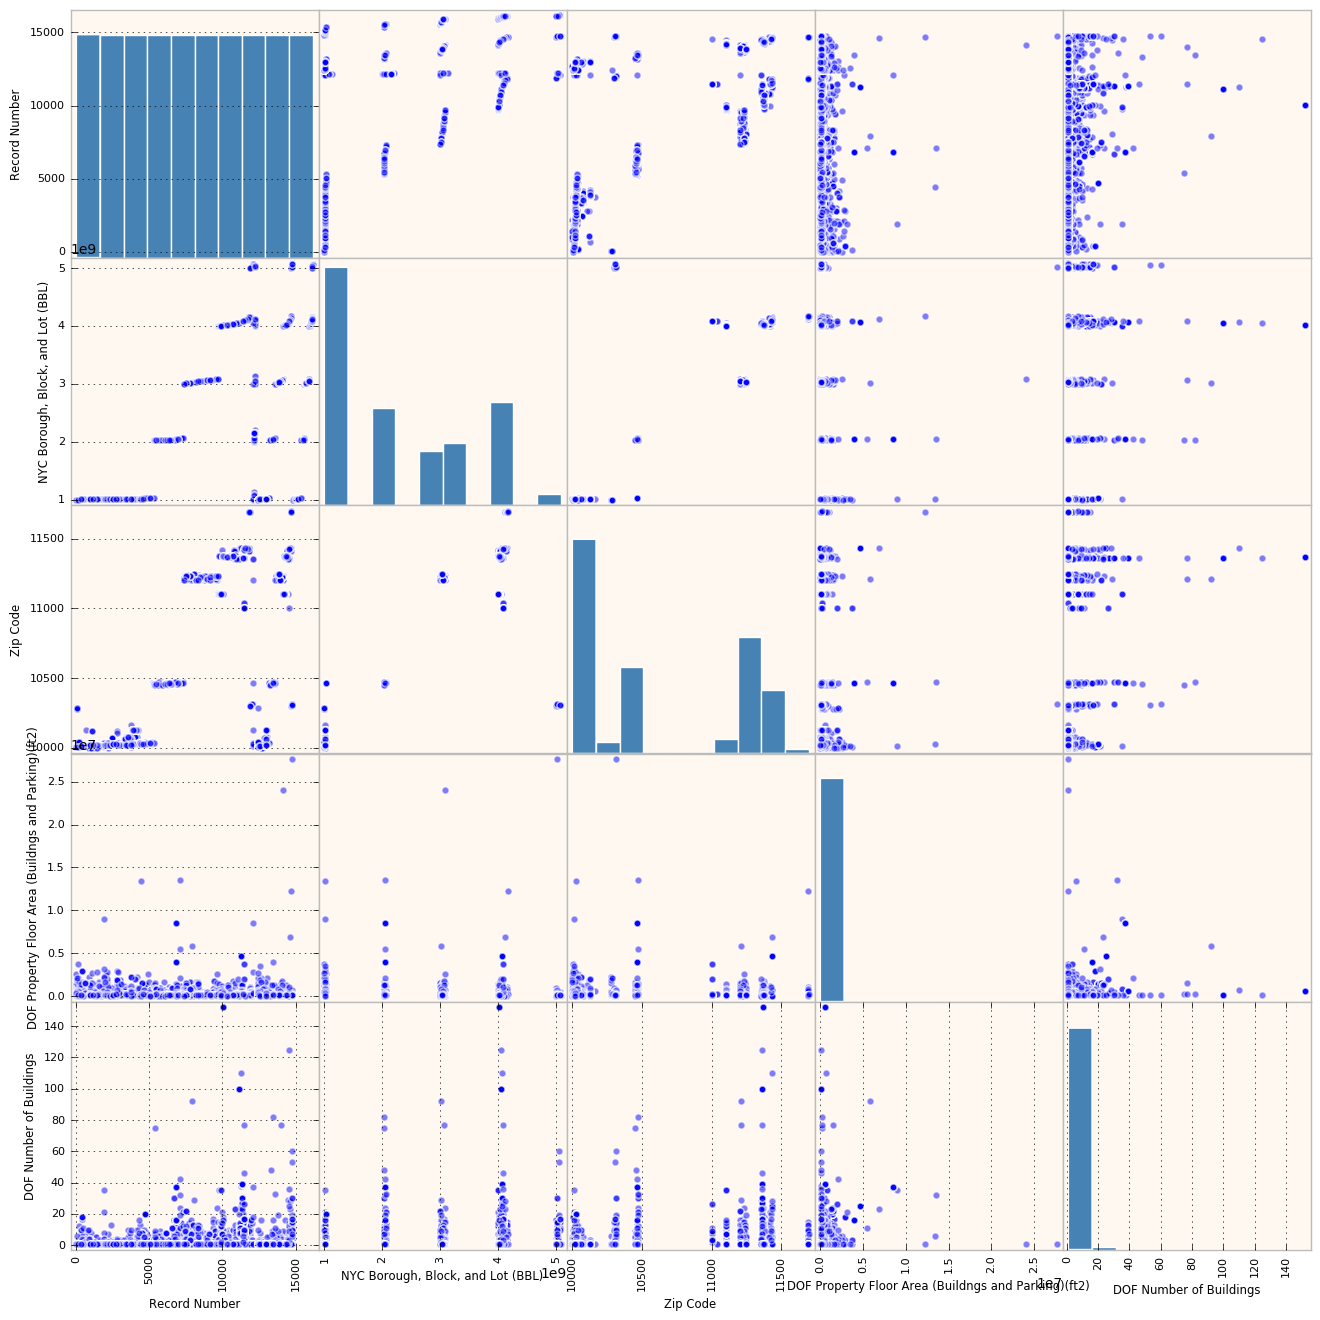

In [4]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix (nrg, s = 100, figsize=(16, 16))

In [5]:
nrg['BBL'] = nrg['NYC Borough, Block, and Lot (BBL)']
nrg = nrg[[10, 21, int(25)]].copy()
#nrg.rename(columns = {'NYC Borough, Block, and Lot (BBL)': 'BBL'}, inplace = True)
nrg.head()

,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),BBL
0,NaN,918919,1.000410e+09
1,NaN,NaN,4.021460e+09
2,NaN,64200,2.027620e+09
3,NaN,NaN,1.006700e+09
4,NaN,50000,2.048300e+09


In [6]:
def canconvert(mydata):
    try :
        float(mydata)
        return True
    except ValueError:
        return False

In [7]:
indx = (np.vectorize(canconvert)(nrg['Site EUI(kBtu/ft2)']))
print ("invalid entries changed to NaN %d"%sum(indx))
nrg['Site EUI(kBtu/ft2)'][~indx] = float('NaN')

indx2 = (np.vectorize(canconvert)(nrg['Reported Property Floor Area (Building(s)) (ft²)']))
print ("invalid entries changed to NaN %d"%sum(indx2))
nrg['Reported Property Floor Area (Building(s)) (ft²)'][~indx2] = float('NaN')

invalid entries changed to NaN 15513


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


invalid entries changed to NaN 15430


In [8]:
nrg.head()

,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),BBL
0,NaN,918919,1.000410e+09
1,NaN,NaN,4.021460e+09
2,NaN,64200,2.027620e+09
3,NaN,NaN,1.006700e+09
4,NaN,50000,2.048300e+09


## Getting and preparing PLUTO data


In [9]:
def getData(url):
    a = os.system("curl -O " + url)
    print (a)
    a = os.system("unzip -jn mn_mappluto_16v1.zip MN*")
    print (a)
    a = os.system("mv " + "MN* " + os.getenv("PUIDATA") + "/MnPLUTO")
    print (a)
getData("https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/mn_mappluto_16v1.zip")

0
0
0


In [10]:
bsize = gpd.read_file (os.getenv("PUIDATA") + "/MnPLUTO/MNMapPLUTO.shp")
bsize.head()

,APPBBL,APPDate,Address,AllZoning1,AllZoning2,AreaSource,AssessLand,AssessTot,BBL,BldgArea,...,YearAlter2,YearBuilt,ZMCode,ZipCode,ZoneDist1,ZoneDist2,ZoneDist3,ZoneDist4,ZoneMap,geometry
0,0.000000e+00,None,1592 2 AVENUE,C1-9/TA,None,2,468000.0,1435950.0,1.015450e+09,10885,...,0,1920,None,10028,C1-9,None,None,None,9a,"POLYGON ((997277.2344000041 221816.0936000049,..."
1,1.007230e+09,11/30/2006,263 9 AVENUE,C1-5/R8,None,2,539984.0,11879993.0,1.007238e+09,89203,...,0,1914,None,10001,R8,None,None,None,8d,"POLYGON ((984164.5626000017 211846.0703999996,..."
2,0.000000e+00,None,310 EAST 109 STREET,R7A,None,2,140102.0,343271.0,1.016800e+09,12000,...,0,1910,None,10029,R7A,None,None,None,6b,"POLYGON ((1000742.195800006 227910.6640000045,..."
3,0.000000e+00,None,720 PARK AVENUE,R10/PI/LH-1A,R8B,2,5040000.0,30591900.0,1.013850e+09,203490,...,2006,1928,None,10021,R10,R8B,None,None,8c,"POLYGON ((994007.6886000037 219880.428399995, ..."
4,0.000000e+00,None,3 WEST 83 STREET,R8B,R10A,2,437850.0,1267200.0,1.011970e+09,13839,...,0,1900,None,10024,R8B,R10A,None,None,5d,"POLYGON ((992273.6850000024 224863.4904000014,..."


In [11]:
bsize.columns

Index([    u'APPBBL',    u'APPDate',    u'Address', u'AllZoning1',
       u'AllZoning2', u'AreaSource', u'AssessLand',  u'AssessTot',
              u'BBL',   u'BldgArea',  u'BldgClass',  u'BldgDepth',
        u'BldgFront',      u'Block',   u'BoroCode',    u'Borough',
         u'BsmtCode',  u'BuiltCode',   u'BuiltFAR',     u'CB2010',
               u'CD',     u'CT2010',    u'ComArea',    u'CommFAR',
          u'CondoNo',    u'Council',  u'EDesigNum',  u'Easements',
       u'ExemptLand',  u'ExemptTot',        u'Ext',   u'FacilFAR',
       u'FactryArea',   u'FireComp', u'GarageArea', u'HealthArea',
         u'HistDist', u'IrrLotCode',    u'LandUse',   u'Landmark',
              u'Lot',    u'LotArea',   u'LotDepth',   u'LotFront',
          u'LotType',  u'LtdHeight', u'MAPPLUTO_F',   u'NumBldgs',
        u'NumFloors', u'OfficeArea',  u'OtherArea',   u'Overlay1',
         u'Overlay2',  u'OwnerName',  u'OwnerType', u'PLUTOMapID',
       u'PolicePrct',   u'ProxCode',    u'ResArea',   u'ResidF

In [12]:
bsize = bsize[['BBL', 'UnitsTotal']].copy()
bsize.head()

,BBL,UnitsTotal
0,1.015450e+09,18
1,1.007238e+09,50
2,1.016800e+09,10
3,1.013850e+09,32
4,1.011970e+09,26


In [13]:
bblnrg = pd.merge(nrg, bsize, how='inner', on='BBL')
bblnrg.head()

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/pandas/indexes/base.py:2097: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  indexer = self._engine.get_indexer(target._values)


,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),BBL,UnitsTotal
0,NaN,NaN,1.006700e+09,1
1,NaN,NaN,1.004370e+09,4
2,125.4,330000,1.013110e+09,56
3,NaN,NaN,1.009220e+09,148
4,NaN,68329,1.007400e+09,1


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4a7ba2a690>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f4a88c40c50>]], dtype=object)

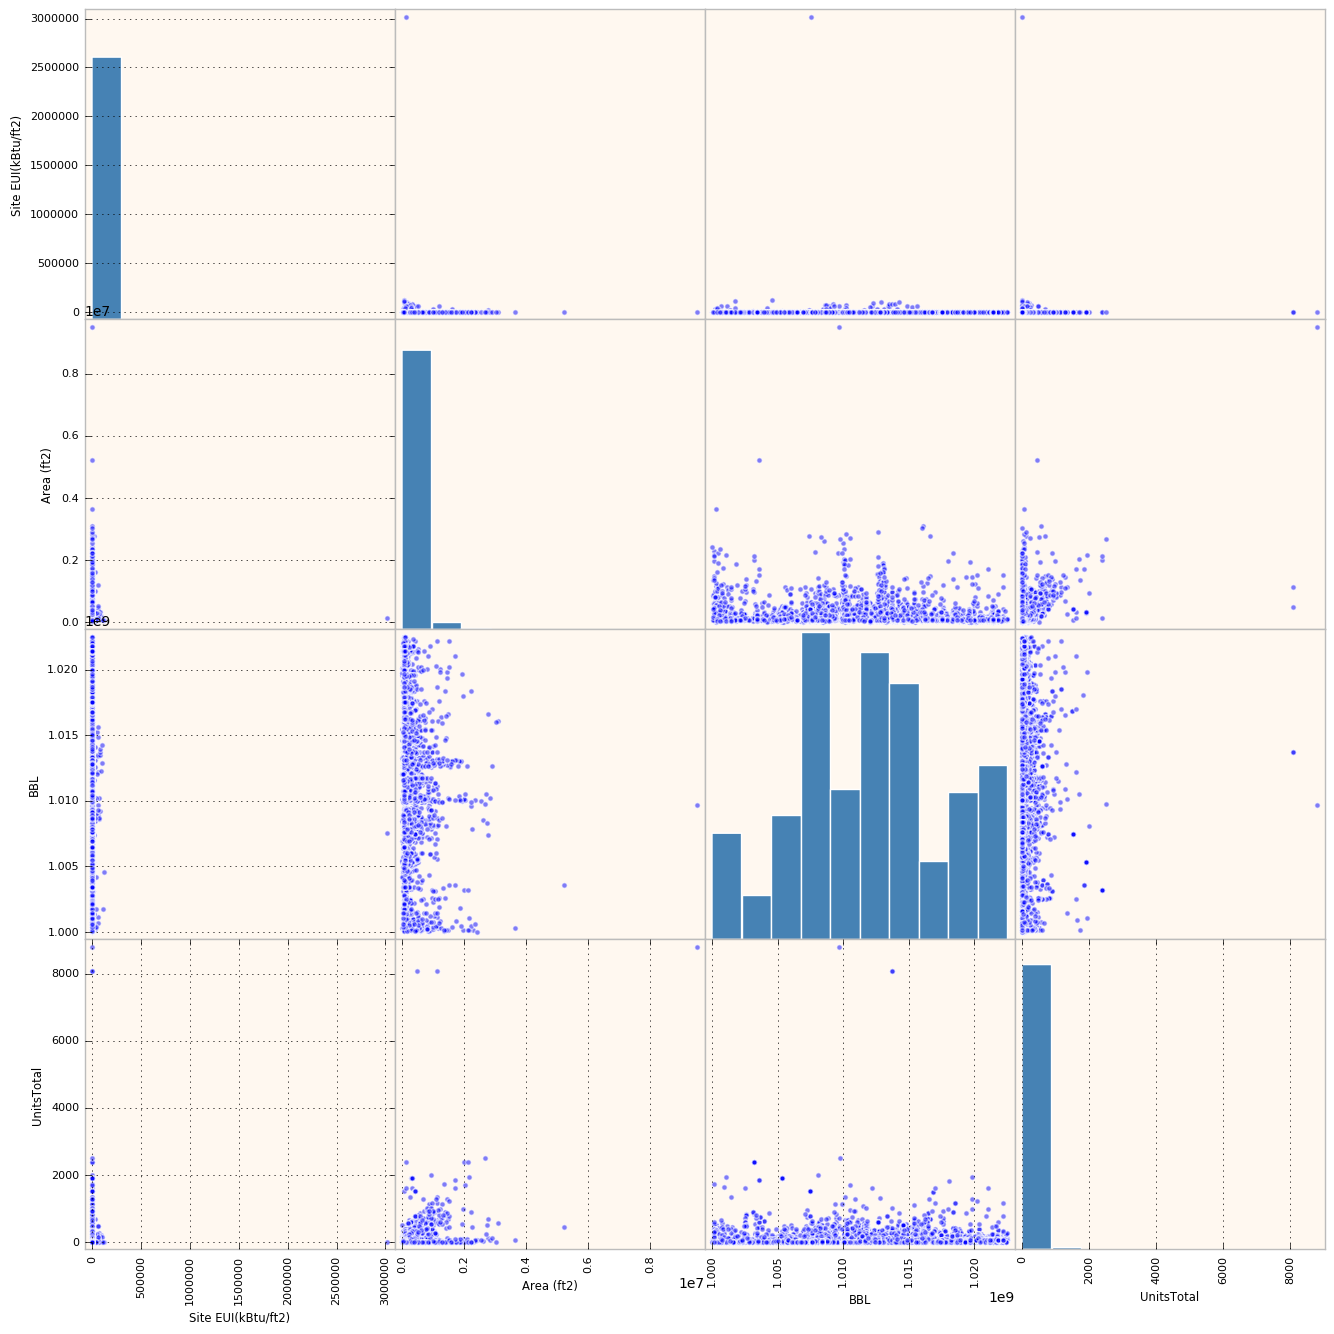

In [14]:
bblnrg['Site EUI(kBtu/ft2)'] = pd.to_numeric(bblnrg['Site EUI(kBtu/ft2)'], errors='coerce')
bblnrg.rename(columns = {'Reported Property Floor Area (Building(s)) (ft²)': 'Area (ft2)'}, inplace = True)
bblnrg['Area (ft2)'] = pd.to_numeric(bblnrg['Area (ft2)'], errors='coerce')

scatter_matrix (bblnrg, s = 60, figsize=(16, 16))

In [15]:
#Find energy total per unit
bblnrg['TotalEnergy'] = bblnrg['Site EUI(kBtu/ft2)'] * bblnrg['Area (ft2)']

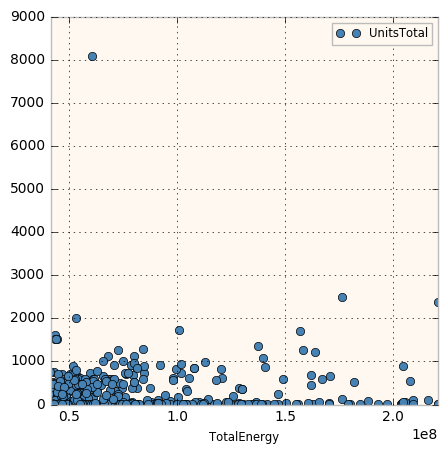

In [17]:
bblnrg = bblnrg[((bblnrg['TotalEnergy'] >= 1000) & (bblnrg.UnitsTotal != 0) )]
bblnrg.plot(x='TotalEnergy', y='UnitsTotal', style='o', figsize=(5, 5))

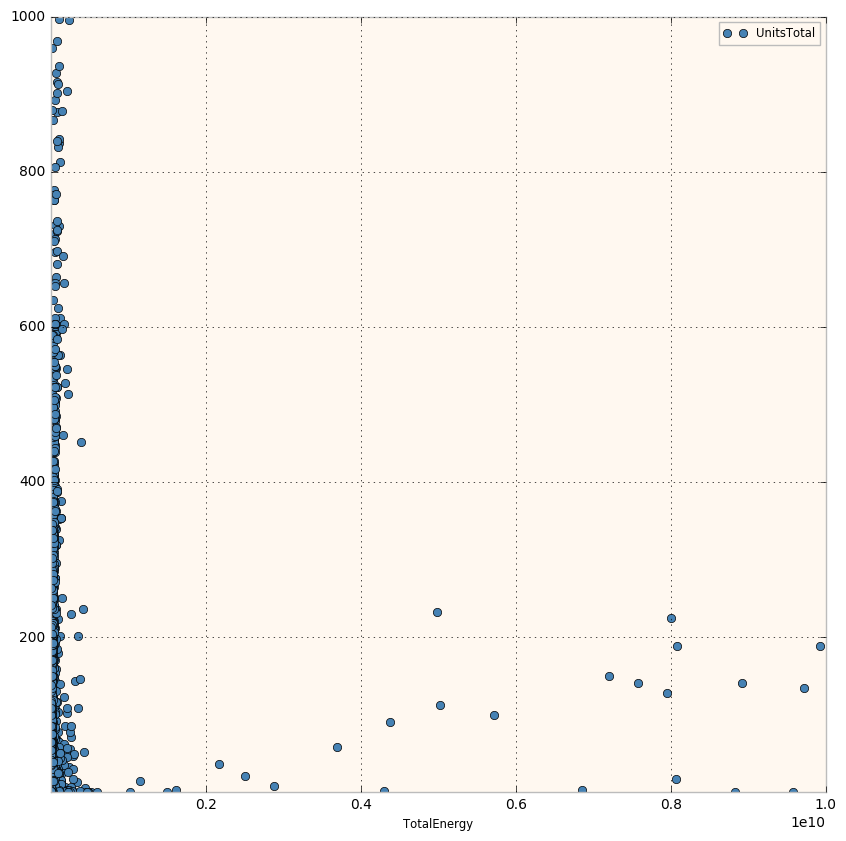

In [18]:
bblnrg.plot(x='TotalEnergy', y='UnitsTotal', style='o', xlim=(1000, 1e10), ylim=(1, 1000), figsize=(10, 10))

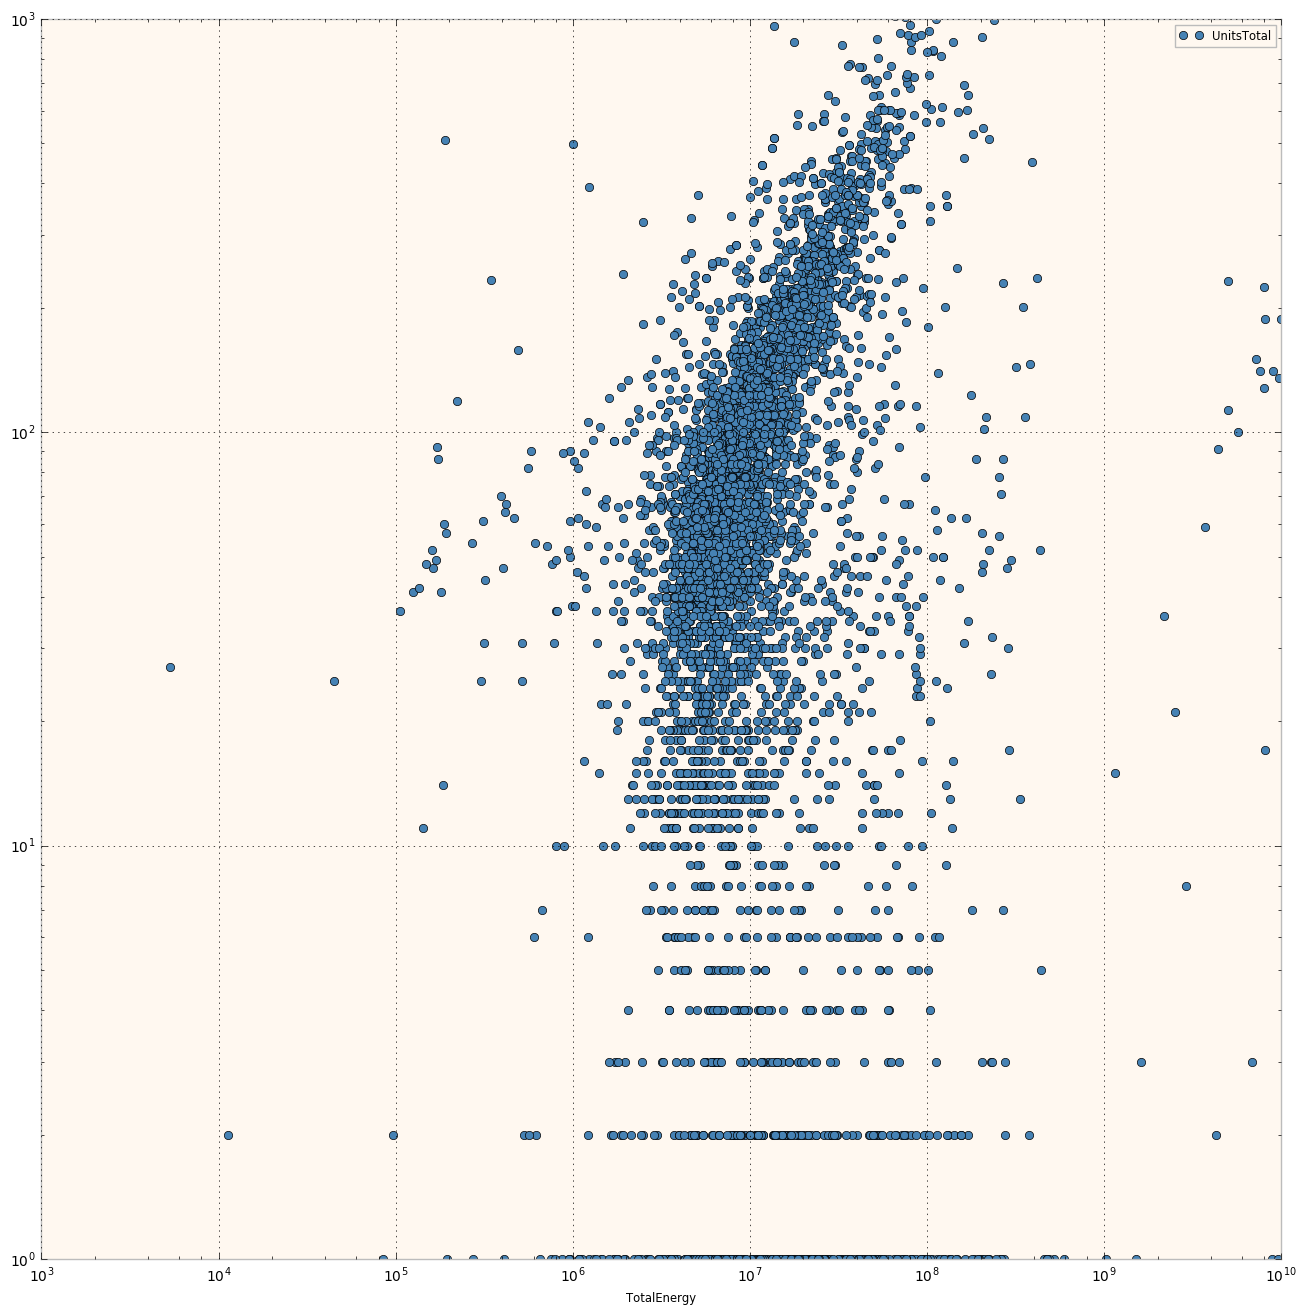

In [19]:
bblnrg.plot(x='TotalEnergy', y='UnitsTotal', style='o', xlim=(1000, 1e10), ylim=(1, 1000), figsize=(16, 16), loglog=True)

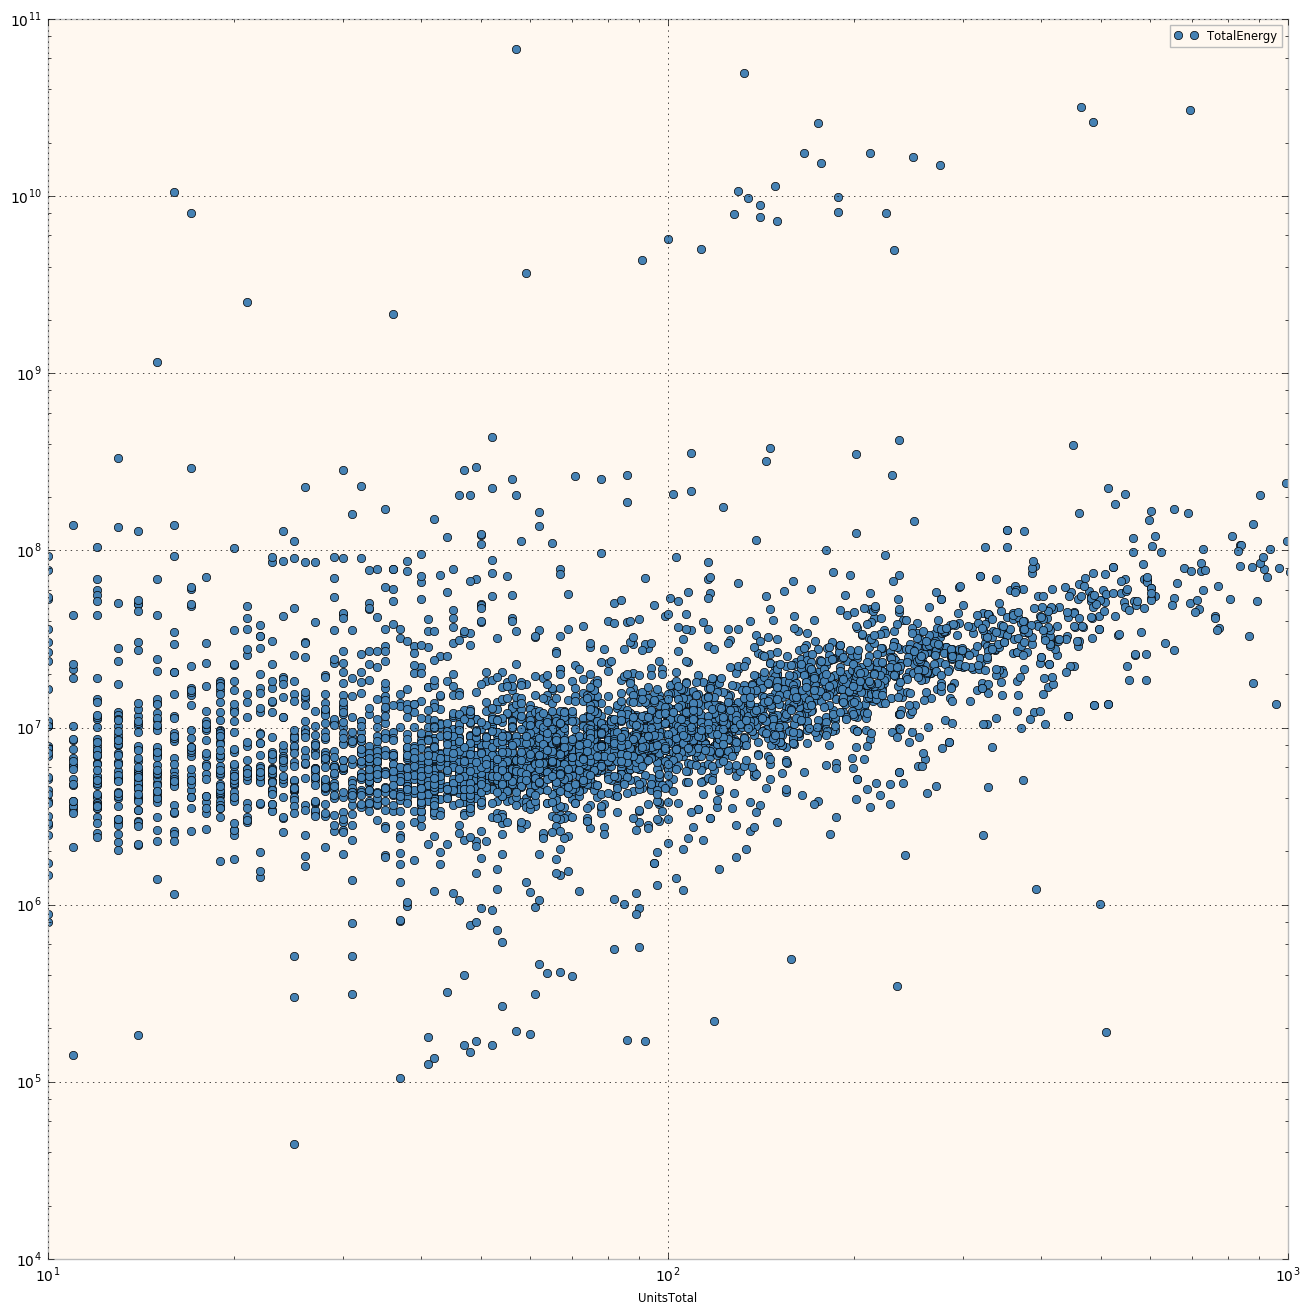

In [20]:
bblnrg.plot(x='UnitsTotal', y='TotalEnergy', style='o', xlim=(10,1000), ylim=(10000,1e11), figsize=(16, 16), loglog=True)

In [28]:
X = sm.add_constant(np.log10(bblnrg['UnitsTotal']))
linmodel = sm.OLS(np.log10(bblnrg['TotalEnergy']), X, missing='drop').fit()
linmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            TotalEnergy   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     63.79
Date:                Tue, 18 Oct 2016   Prob (F-statistic):           1.70e-15
Time:                        21:40:43   Log-Likelihood:                -3867.6
No. Observations:                4997   AIC:                             7739.
Df Residuals:                    4995   BIC:                             7752.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          6.9116      0.020    353.804      0.000         6.873     6.950
UnitsTotal     0.0865      0.011      7.987      0.000         0.065     0.108
==============================================================================
Omnibus:                     2221.478   Durbin-Watson:                   1.683
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            27205.366
Skew:                           1.791   Prob(JB):                         0.00
Kurtosis:                      13.855   Cond. No.                         6.04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
X2 = sm.add_constant(np.log10(bblnrg['TotalEnergy']))
linmodel2 = sm.OLS(np.log10(bblnrg['UnitsTotal']), X2, missing='drop').fit()
linmodel2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             UnitsTotal   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     63.79
Date:                Tue, 18 Oct 2016   Prob (F-statistic):           1.70e-15
Time:                        21:40:43   Log-Likelihood:                -5173.8
No. Observations:                4997   AIC:                         1.035e+04
Df Residuals:                    4995   BIC:                         1.036e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
const           0.6401      0.129      4.954      0.000         0.387     0.893
TotalEnergy     0.1458      0.018      7.987      0.000         0.110     0.182
==============================================================================
Omnibus:                      754.081   Durbin-Watson:                   1.517
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1145.004
Skew:                          -1.090   Prob(JB):                    2.32e-249
Kurtosis:                       3.863   Cond. No.                         96.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

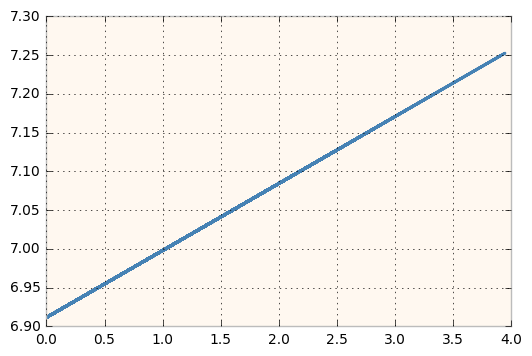

In [33]:
pl.plot(np.log10(bblnrg['UnitsTotal']), linmodel.predict())